# MNIST

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


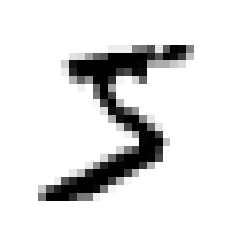

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.values[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
import numpy as np

In [9]:
y = y.astype(np.uint8)

## 데이터 분리

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진분류기 훈련
### 5가 맞으면 1, 아니면 0

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# SGDClassifier

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

    - 5의 픽셀 데이터를 Predict에 넣었더니 True(=5 맞음) 으로 잘 예측했다!

# 성능 측정

## 교차검증을 사용한 정확도 측정
    - StatifiedKFold : k개의 fold를 분할한 이후에도 전체 훈련 데이터의 클래스 비율과 
      각 fold가 갖고 있는 클래스의 비율을 맞춰준다.

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


    - fold 정확도가 91% ~ 96%로 잘 예측한다!

### cross_val_score()
    - 폴드가 3개인 K-겹 교차검증을 사용해 SGDClassifier 모델 평가

In [26]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

    - cross_val_score 결과도 각각 95% ~ 96%로 잘 예측한다!

In [27]:
from sklearn.base import BaseEstimator

class Never5Classfier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never_5_clf = Never5Classfier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### 정확도 90% 이상! 
    - 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%! 

# 오차 행렬

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [33]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# 정밀도와 재현율

In [34]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [35]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [36]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# 정밀도 / 재현율 트레이드오프

In [37]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [42]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [43]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [44]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [57]:
plt.rcParams['font.family'] = 'AppleGothic'

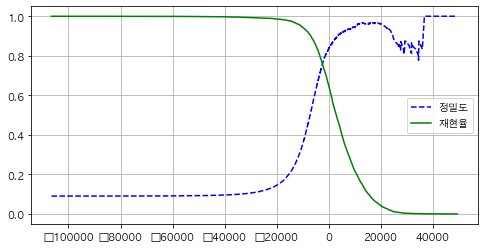

In [60]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8,4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
    plt.legend()
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [61]:
threshold_90_precision = thresholds[np.argmax(precisions < 0.90)]

In [62]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [63]:
precision_score(y_train_5, y_train_pred_90)

0.0904012273621719

In [64]:
recall_score(y_train_5, y_train_pred_90)

1.0

# ROC 곡선

In [67]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

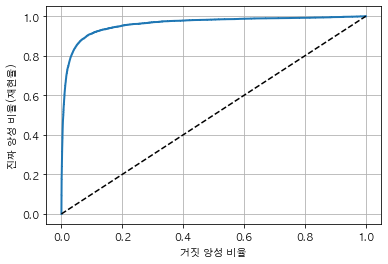

In [71]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('거짓 양성 비율')
    plt.ylabel('진짜 양성 비율(재현율)')
    plt.grid()
    #plt.legend()

plot_roc_curve(fpr, tpr)
plt.show()

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [74]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [75]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

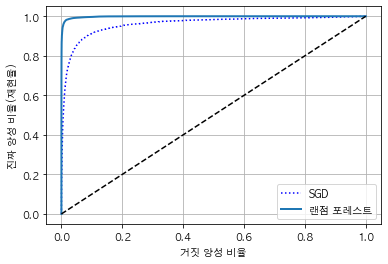

In [78]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, '랜점 포레스트')
plt.legend(loc='lower right')
plt.show()

### RFC의 ROC가 왼쪽 위 모서리에 더 가까움 = SGD보다 성능 좋음

In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [80]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### RFC의 auc = 0.99 / SGD의 auc = 0.96

# 다중 분류

In [81]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [82]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

    - 분류기가 5임을 가장 크게 확신하고 있다! 

In [83]:
np.argmax(some_digit_scores)

5

In [84]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [85]:
svm_clf.classes_[5]

5

    - 인덱스 5에 해당하는 클래스 값은 5

In [86]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifierassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [87]:
len(ovr_clf.estimators_)

10

In [88]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [89]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [90]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [91]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# 에러 분석

In [93]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

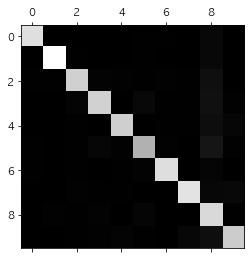

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

    - 숫자가 낮을수록 까맣다. 
        * 대각선은 맞춘 개수를 의미함. = 많이 맞췄으니까 흰색에 가까워! 
        * 나머지는 틀린갯수인데, 맞춘개수가 월등히 많다보니 다 그냥 까매보인다. 자세히 보고싶어!

In [95]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

    - 맞추지 못한 부분을 자세히 보기 위해 대각선에 모두 0으로 대체하고 살펴본다.

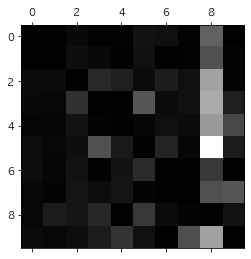

In [96]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

    - 클래스 8의 열이 대체로 하얗다! = 잘못 분류 되었다! 
        * 열은 하얗지만, 행은 하얗지 않다! = 실제 8이 8로 잘 분류되었다! 
        

In [120]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


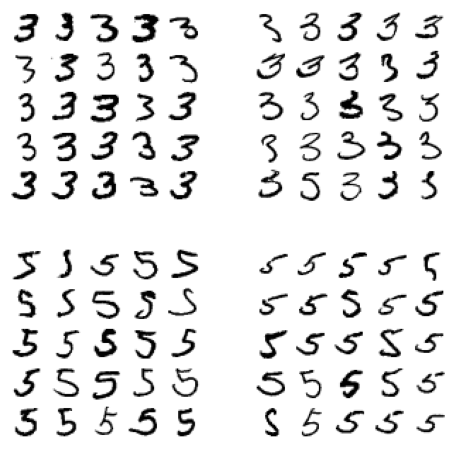

In [124]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25].values, images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25].values, images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25].values, images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25].values, images_per_row=5)
plt.show()

- 왼쪽 두 블록 : 3으로 분류된 이미지 
- 오른쪽 두 블록 : 5로 분류된 이미지 

    - HandsONML에서는 plot_digits에 X_aa[:25]만 써넣었는데 그러면 
    'str' object has no attribute 'reshape' 이라는 에러가 생긴다. 그래서 X_aa[:25].values로 대체해야 한다.

# 다중 레이블 분류

In [125]:
from sklearn.neighbors import KNeighborsClassifier

y_train_larget = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_larget, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [126]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [127]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# 다중 출력 분류

In [155]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

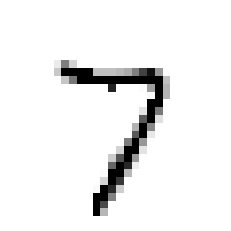

In [161]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digits(clean_digit)